### Dataset Aggregation and Summary

This script collects all previously recorded gesture CSV files and merges them into a single dataset.

Processing steps:

1. Searches the `../data/raw` directory for all `.csv` files  
2. Loads each file into a separate pandas DataFrame  
3. Concatenates them into one unified DataFrame (`combined_df`)  
   - All gesture samples from different recording sessions are combined
   - Indexes are reset to ensure consistency

After merging, the dataset can be analyzed, including:

- number of samples per gesture label  
- distribution of left vs. right hand samples  

This combined dataset will later be used for model training and evaluation.


In [3]:
import pandas as pd
import os
from glob import glob

In [ ]:
# all raw files 
raw_data_path = "../data/raw"

csv_files = glob(os.path.join(raw_data_path, "*.csv"))

if not csv_files:
    print(" No CVS file was found(((")
else:
    print(f" {len(csv_files)} files were found")

    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)

# Save dataset as new file

In [ ]:
# new file
output_file = "../data/processed/data.csv"
combined_df.to_csv(output_file, index=False)
print(f"Final file was saved to {output_file}. Size: {combined_df.shape}")

## Quick integrity checks
Verifies file can be read, shows first rows, checks for missing columns or NaNs

In [7]:
output_file = "../data/processed/data.csv"
df = pd.read_csv(output_file)

# Quick info
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
display(df.head())

# Basic checks
missing_per_col = df.isna().sum()
print("\nMissing values per column:")
display(missing_per_col[missing_per_col > 0])

# Ensure expected columns (21 landmarks * 3 + 2)
expected_cols = [f"{axis}{i}" for i in range(21) for axis in ("x","y","z")] + ["gesture","is_right_hand"]
missing_expected = [c for c in expected_cols if c not in df.columns]
if missing_expected:
    print("WARNING: missing expected columns:", missing_expected)
else:
    print("All expected columns present.")

Rows: 67774
Columns: ['x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8', 'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12', 'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15', 'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18', 'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'gesture', 'is_right_hand']


,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,y18,z18,x19,y19,z19,x20,y20,z20,gesture,is_right_hand
0,0.0,0.0,0.0,-0.106621,-0.166856,-0.033814,-0.139544,-0.419997,-0.042286,-0.168043,...,-0.351569,-0.158770,0.180532,-0.289552,-0.169988,0.128119,-0.228281,-0.165538,three1,1
1,0.0,0.0,0.0,-0.108740,-0.159318,-0.032455,-0.142569,-0.414363,-0.036965,-0.169337,...,-0.358670,-0.152507,0.175419,-0.292908,-0.163981,0.124854,-0.228670,-0.159092,three1,1
2,0.0,0.0,0.0,-0.109081,-0.151004,-0.029950,-0.154203,-0.402066,-0.036120,-0.185443,...,-0.374543,-0.160428,0.154250,-0.314736,-0.169843,0.107185,-0.251618,-0.163476,three1,1
3,0.0,0.0,0.0,-0.102910,-0.150929,-0.029678,-0.143355,-0.392298,-0.037267,-0.169198,...,-0.367137,-0.163880,0.149049,-0.301855,-0.171421,0.105756,-0.239759,-0.163356,three1,1
4,0.0,0.0,0.0,-0.107537,-0.156056,-0.035976,-0.152639,-0.397539,-0.047153,-0.179055,...,-0.344579,-0.172718,0.150836,-0.287045,-0.176720,0.105458,-0.232488,-0.165231,three1,1



Missing values per column:


Series([], dtype: int64)

All expected columns present.


# High-level summary: counts, unique gestures, class balance
- table showing left/right counts per gesture
- color gradient highlights imbalance

In [8]:
pivot = df.pivot_table(index="gesture", columns="is_right_hand", 
                       values="x0", aggfunc="count", fill_value=0)
pivot.columns = ["left_count", "right_count"]
pivot["total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total", ascending=False)
display(pivot.style.background_gradient(cmap="Blues").format("{:.0f}"))


,left_count,right_count,total
gesture,,,
four,2173,2726,4899
question,2112,2614,4726
don,2202,2242,4444
three1,2196,2200,4396
civilian,2104,2194,4298
cool,2000,2252,4252
me,2063,2125,4188
zero,2096,2062,4158
mafia,2133,2022,4155


# Descriptive statistics per coordinate (aggregate)

Checks distribution and scale of normalized coordinates. Look for unexpected out-of-range values.

In [9]:
landmark_cols = [c for c in df.columns if c not in ("gesture","is_right_hand")]
desc = df[landmark_cols].describe().T  # mean, std, min, max, etc.
desc = desc[["count","mean","std","min","25%","50%","75%","max"]]
display(desc.style.format({
    "mean": "{:.3f}", "std": "{:.3f}", "min":"{:.3f}", "25%":"{:.3f}", "50%":"{:.3f}", "75%":"{:.3f}", "max":"{:.3f}"
}))


,count,mean,std,min,25%,50%,75%,max
x0,67774.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
y0,67774.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
z0,67774.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
x1,67774.000000,-0.003,0.117,-0.374,-0.105,-0.016,0.103,0.338
y1,67774.000000,-0.108,0.134,-0.487,-0.192,-0.109,-0.053,0.432
z1,67774.000000,-0.030,0.064,-0.382,-0.067,-0.043,0.000,0.328
x2,67774.000000,-0.004,0.212,-0.694,-0.179,-0.023,0.175,0.635
y2,67774.000000,-0.244,0.246,-0.688,-0.375,-0.270,-0.174,0.664
z2,67774.000000,-0.060,0.095,-0.622,-0.105,-0.068,-0.034,0.489
x3,67774.000000,-0.004,0.266,-0.890,-0.222,-0.005,0.213,0.800


# Landmark-wise dispersion per gesture (boxplots)


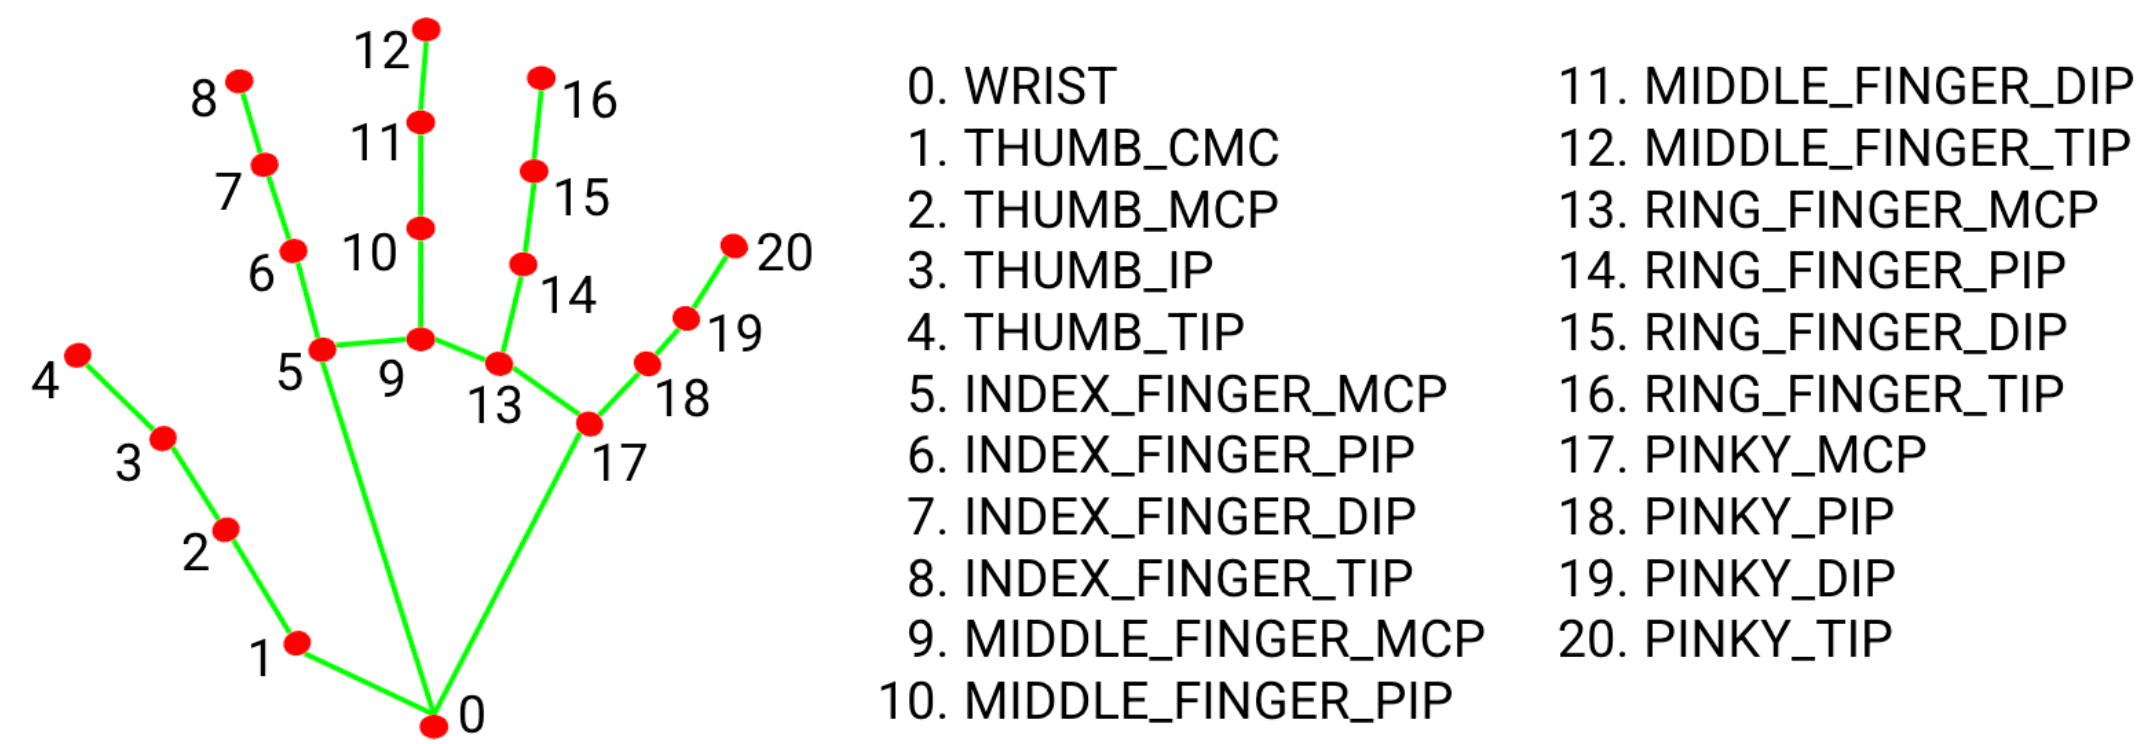

<Figure size 1200x600 with 0 Axes>

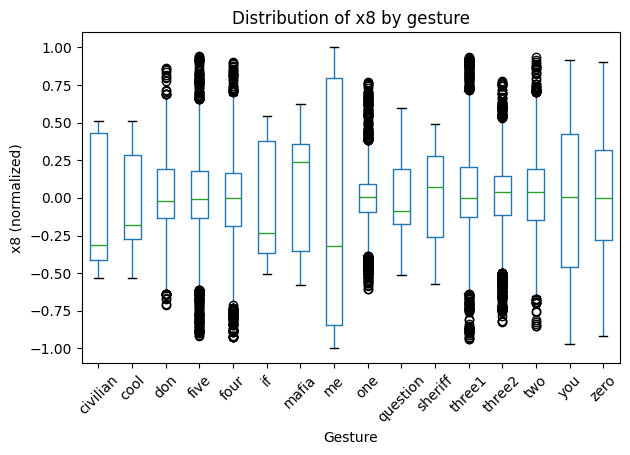

In [10]:
import matplotlib.pyplot as plt

landmark = "x8"  # can change to other landmarks to inspect
plt.figure(figsize=(12,6))
combined_df.boxplot(column=landmark, by="gesture", rot=45, grid=False)
plt.title(f"Distribution of {landmark} by gesture")
plt.suptitle("")
plt.xlabel("Gesture")
plt.ylabel(f"{landmark} (normalized)")
plt.tight_layout()
plt.show()


# Mean hand shape per gesture (skeleton average) — numeric + visual

Compute mean 21×3 vector per gesture and visualize as a skeleton overlay. Average skeletons reveal per-gesture canonical pose; useful for sanity checks and for presenting prototypes.

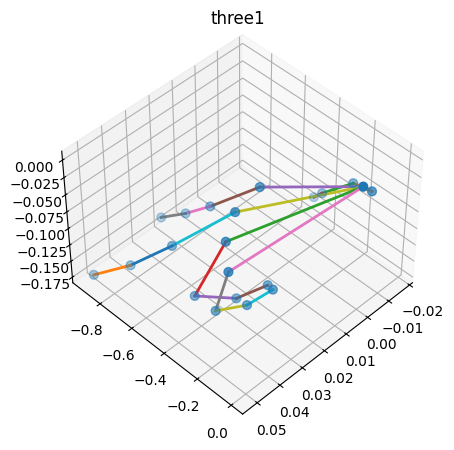

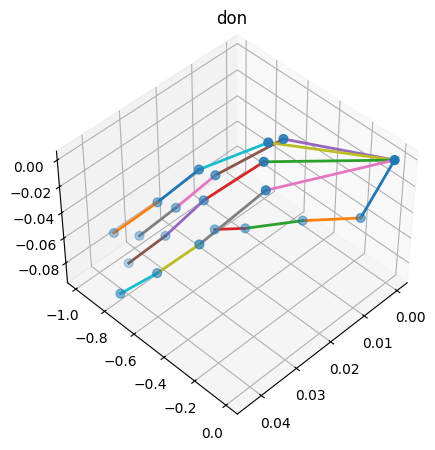

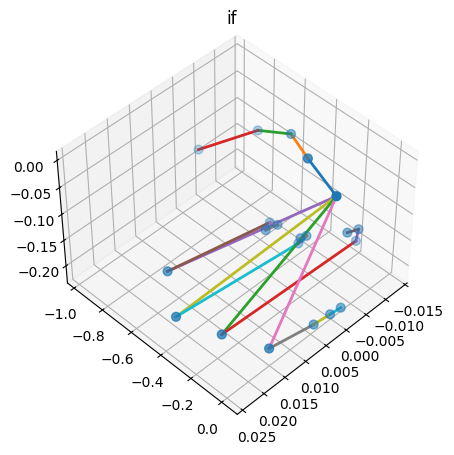

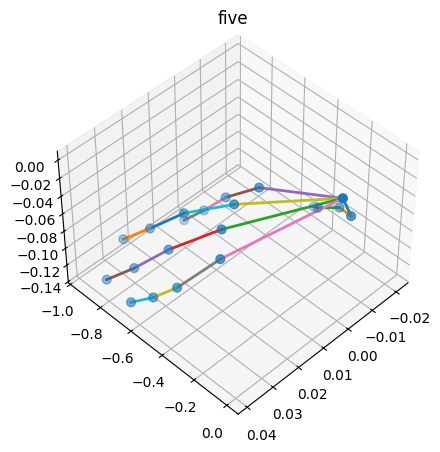

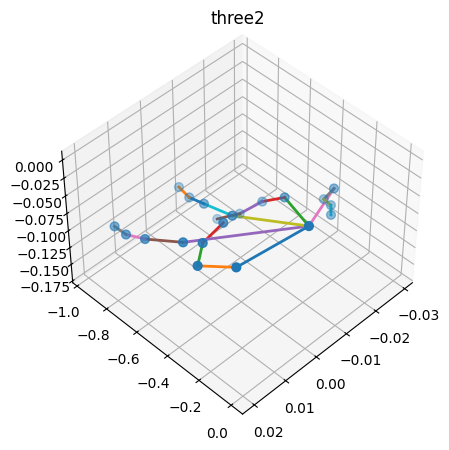

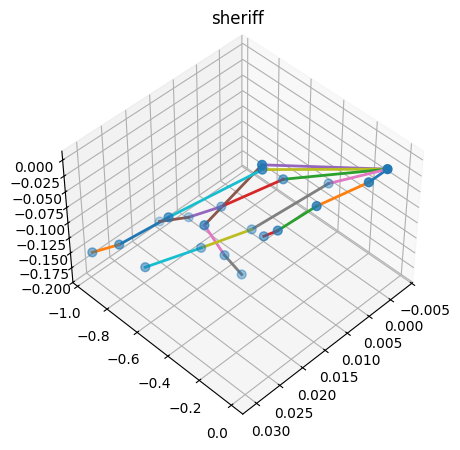

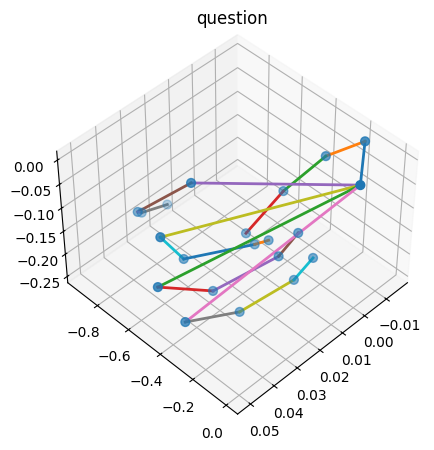

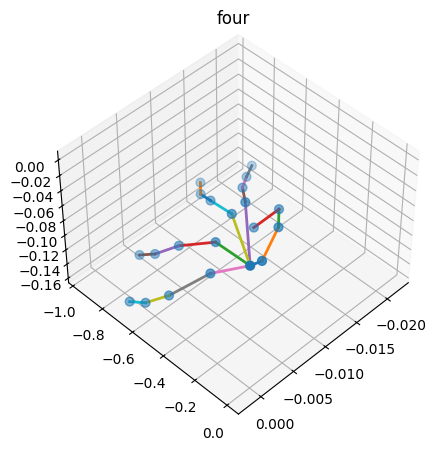

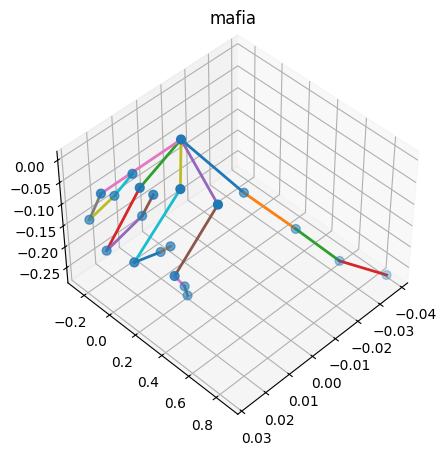

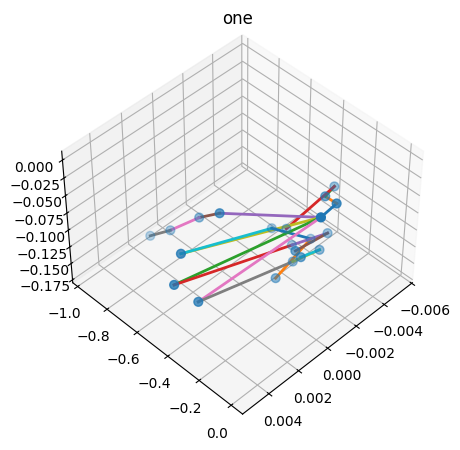

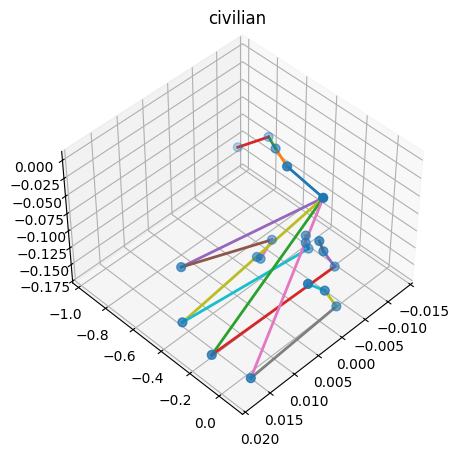

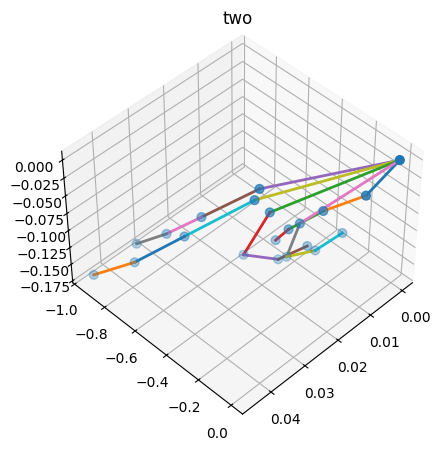

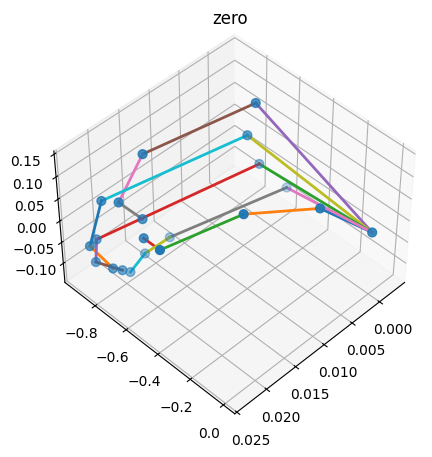

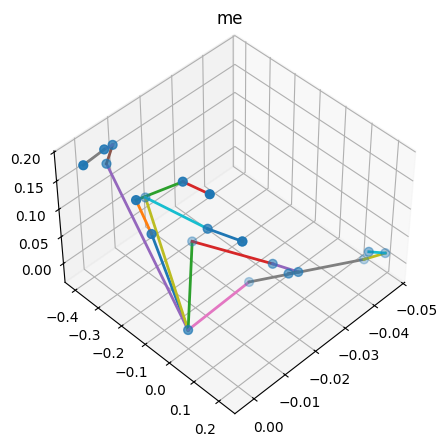

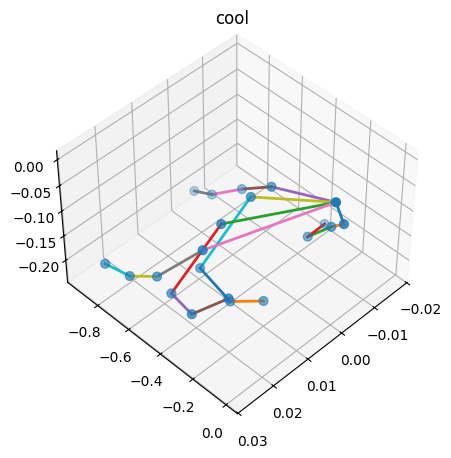

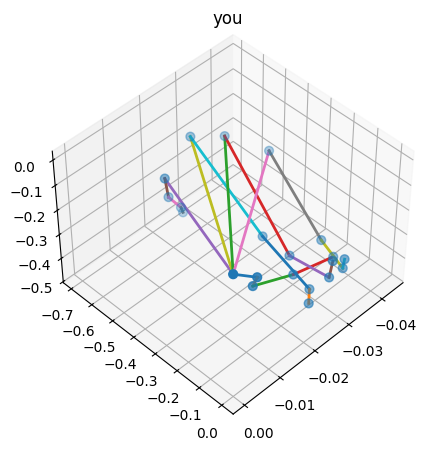

In [11]:
# Cell: mean landmark per gesture and plotting helper
import numpy as np

# Mediapipe hand connections (pairs of landmark indices)
CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),      # thumb
    (0,5),(5,6),(6,7),(7,8),      # index
    (0,9),(9,10),(10,11),(11,12), # middle
    (0,13),(13,14),(14,15),(15,16),# ring
    (0,17),(17,18),(18,19),(19,20) # pinky
]

def mean_shape_for_gesture(g):
    sub = df[df["gesture"]==g]
    arr = sub[landmark_cols].values
    mean_vec = np.nanmean(arr, axis=0)  # shape (63,)
    coords = mean_vec.reshape(21,3)
    return coords

gestures = df["gesture"].unique() 


for i in range(len(gestures)):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    coords = mean_shape_for_gesture(gestures[i])
    x, y, z = coords[:,0], coords[:,1], coords[:,2]

    ax.scatter(x, y, z, s=40)

    for (a,b) in CONNECTIONS:
        ax.plot([x[a],x[b]], [y[a],y[b]], [z[a],z[b]], linewidth=2)

    ax.set_title(gestures[i])
    ax.view_init(elev=45, azim=45) 
    plt.show()

